# Showcase of the "to_sql" functionality of mlinspect

It will be shown how parts of the original mlinspect example pipelines
"healthcare" and "compas" will be inspected using the additional "to_sql"
functionality.

## First install the required packages

In [1]:
# Install the pip packages in the current Jupyter kernel
import pathlib
import sys
!{sys.executable} -m pip install faker

## Some parameters you might want to set:#

In [2]:
from mlinspect.to_sql.dbms_connectors.postgresql_connector import PostgresqlConnector
from mlinspect.to_sql.dbms_connectors.umbra_connector import UmbraConnector
from pandas_connector import PandasConnector
from _benchmark_utility import plot_compare, ROOT_DIR, PLOT_DIR
from _code_as_string import Join, GroupBy, Selection, Projection
import matplotlib.pyplot as plt

UMBRA_DIR = r"/home/luca/Documents/Bachelorarbeit/umbra-students"
DO_CLEANUP = True
SIZES = [(10 ** i) for i in range(2, 5, 1)]

# Data Generation

To be able to benchmark and compare the different approaches, some datasets
will need to be generated before. The datasets are just and expansion of the
original ones.

In [3]:
from data_generation._compas_data_generation import generate_compas_dataset
from data_generation._healthcare_data_generation import generate_healthcare_dataset

# compas_tain, compas_test \
COMPAS_DATA_PATHS = generate_compas_dataset(SIZES)
# healthcare_histories, healthcare_patients \
HEALTHCARE_DATA_PATHS = generate_healthcare_dataset(SIZES)

Data generated or found for: size = 100 -- compas
Data generated or found for: size = 1000 -- compas
Data generated or found for: size = 10000 -- compas
Data generated or found for: size = 100 -- healthcare
Data generated or found for: size = 1000 -- healthcare
Data generated or found for: size = 10000 -- healthcare


## Operation performance comparison (not exhaustive)

No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


ITERATION: 0 - for table size of: 10
Executing Query in Umbra...
Done in 0.00015159999999999997!
Executing Query in Postgres...
Done in 0.1661!
Executing Query in Pandas...
Done in 5.2119509999101865!
Executing Query in Umbra...
Done in 6.969999999999999e-05!
Executing Query in Postgres...
Done in 0.038200000000000005!
Executing Query in Pandas...
Done in 2.0973257000150625!
Executing Query in Umbra...
Done in 0.00018599999999999997!
Executing Query in Postgres...
Done in 0.05079999999999999!
Executing Query in Pandas...
Done in 2.0894274000966107!
Executing Query in Umbra...
Done in 0.0003611!
Executing Query in Postgres...
Done in 0.1316!
Executing Query in Pandas...
Done in 4.415974600124173!


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


ITERATION: 1 - for table size of: 100
Executing Query in Umbra...
Done in 0.0008550000000000001!
Executing Query in Postgres...
Done in 2.5728999999999997!
Executing Query in Pandas...
Done in 6.286476999957813!
Executing Query in Umbra...
Done in 0.0002379!
Executing Query in Postgres...
Done in 0.2577!
Executing Query in Pandas...
Done in 2.415727399966272!
Executing Query in Umbra...
Done in 0.0001237!
Executing Query in Postgres...
Done in 0.34010000000000007!
Executing Query in Pandas...
Done in 2.492799500032561!
Executing Query in Umbra...
Done in 0.0003474!
Executing Query in Postgres...
Done in 0.6932!
Executing Query in Pandas...
Done in 5.054322300020431!


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


ITERATION: 2 - for table size of: 1000
Executing Query in Umbra...
Done in 0.0037941000000000003!
Executing Query in Postgres...
Done in 30.729499999999994!
Executing Query in Pandas...
Done in 20.659322400024394!
Executing Query in Umbra...
Done in 0.0009146!
Executing Query in Postgres...
Done in 1.1766!
Executing Query in Pandas...
Done in 5.6836554000256!
Executing Query in Umbra...
Done in 0.0002307!
Executing Query in Postgres...
Done in 1.7165!
Executing Query in Pandas...
Done in 5.529232799926831!
Executing Query in Umbra...
Done in 0.0005372!
Executing Query in Postgres...
Done in 2.1515!
Executing Query in Pandas...
Done in 9.292400199956319!


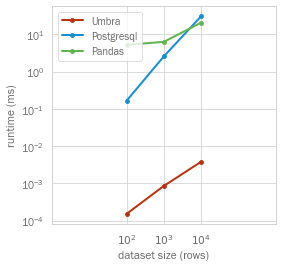

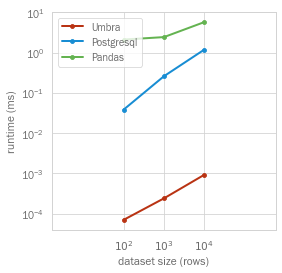

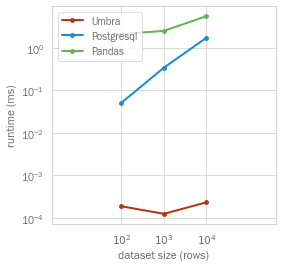

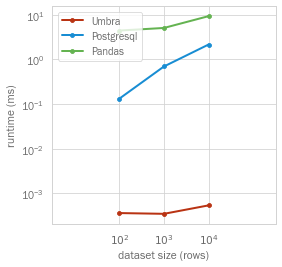

In [4]:
# Based on mlinspect benchmarks.
t1_name = "histories"
t2_name = "patients"

operations = ["Join", "Select", "Project", "GroupBy"]

umbra_times = [[] for _ in operations]
postgres_times = [[] for _ in operations]
pandas_times = [[] for _ in operations]

postgres = PostgresqlConnector(dbname="healthcare_benchmark", user="luca", password="password", port=5432,
                               host="localhost")
pandas = PandasConnector()
repetitions = 10
for i, (table1, table2) in enumerate(HEALTHCARE_DATA_PATHS):

    umbra = UmbraConnector(dbname="", user="postgres", password=" ", port=5433, host="/tmp/",
                           umbra_dir=UMBRA_DIR)

    umbra.add_csv(table_name=t2_name, path_to_csv=table2, null_symbols=["?"], delimiter=",", header=True)
    umbra.add_csv(table_name=t1_name, path_to_csv=table1, null_symbols=["?"], delimiter=",", header=True)

    postgres.add_csv(table_name=t2_name, path_to_csv=table2, null_symbols=["?"], delimiter=",", header=True)
    postgres.add_csv(table_name=t1_name, path_to_csv=table1, null_symbols=["?"], delimiter=",", header=True)

    print(f"ITERATION: {i} - for table size of: {(10 ** (i + 1))}")

    input_join = t1_name, t2_name, "ssn"
    umbra_times[0].append(umbra.benchmark_run(Join.get_sql_code(*input_join), repetitions))
    postgres_times[0].append(postgres.benchmark_run(Join.get_sql_code(*input_join), repetitions))
    pandas_times[0].append(
        pandas.benchmark_run(Join.get_pandas_code(table1, table2, "ssn"), repetitions=repetitions))

    input_sel = t1_name, "complications", ">", "5"
    umbra_times[1].append(umbra.benchmark_run(Selection.get_sql_code(*input_sel), repetitions))
    postgres_times[1].append(postgres.benchmark_run(Selection.get_sql_code(*input_sel), repetitions))
    pandas_times[1].append(
        pandas.benchmark_run(Selection.get_pandas_code(table1, "complications", ">", "5"),
                             repetitions=repetitions))

    input_project = t1_name, "smoker"
    umbra_times[2].append(umbra.benchmark_run(Projection.get_sql_code(*input_project), repetitions))
    postgres_times[2].append(postgres.benchmark_run(Projection.get_sql_code(*input_project), repetitions))
    pandas_times[2].append(
        pandas.benchmark_run(Projection.get_pandas_code(table1, "smoker"), repetitions=repetitions))

    input_project = t1_name, "smoker", "complications", "AVG"
    umbra_times[3].append(umbra.benchmark_run(GroupBy.get_sql_code(*input_project), repetitions))
    postgres_times[3].append(postgres.benchmark_run(GroupBy.get_sql_code(*input_project), repetitions))
    pandas_times[3].append(
        pandas.benchmark_run(GroupBy.get_pandas_code(table1, "smoker", "complications", "mean"),
                             repetitions=repetitions))
    # in the end we have 3 lists == [[*joins*][*selections*][*projections*]]

names = ["Umbra", "Postgresql", "Pandas"]
for i, title in enumerate(operations):
    table = [umbra_times[i], postgres_times[i], pandas_times[i]]
    plot = plot_compare(title, SIZES, all_y=table, all_y_names=names, save=True)

### The original results:
**Join**:

![](./plots/Join.png)

**GroupBy**:

![](./plots/GroupBy.png)

**Select**:

![](./plots/Select.png)

**Project**:

![](./plots/Project.png)



In [5]:
# Clean_up:

if DO_CLEANUP:
    [f.unlink() for f in PLOT_DIR.glob("*_*.png") if f.is_file()]